# Feature Engineering

In machine learning, a feature is an individual measurable attribute of a phenomenon being observed. The extraction of features from raw training data is called *feature engineering*. In other words, feature engineering is a process of transforming raw training data into a *representation* suitable for the application of machine learning algorithms.

This process usually requires a certain degree of domain expertise and can be divided into the following stages [[1]](#ref_1): 
- Brainstorming on features
- Deciding what features to create
- Creating features
- Studying how the features impact model's predictive accuracy
- Iterating if necessary

In [1]:
%matplotlib inline
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext, Window
import pyspark.sql.functions as F
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

matplotlib.style.use('ggplot')

## Reading input data

In [2]:
sqlContext = SQLContext(sc)

telemetry_input_df = sqlContext.read.parquet('data/telemetry')
logs_input_df = sqlContext.read.parquet('data/logs')

telemetry_input_df.printSchema()
logs_input_df.printSchema()

telemetry_entries_count = telemetry_input_df.count()
log_entries_count = logs_input_df.count()

print('Total:\n\n{0:10d} telemetry entries\n{1:10d} log entries'.format(
    telemetry_entries_count, log_entries_count))

root
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- machineID: string (nullable = true)
 |-- pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- speed_desired: long (nullable = true)
 |-- temperature: double (nullable = true)

root
 |-- timestamp: timestamp (nullable = true)
 |-- code: string (nullable = true)
 |-- level: string (nullable = true)
 |-- machineID: string (nullable = true)

Total:

  13043552 telemetry entries
       537 log entries


## Data exploration

Let's answer several basic questions about the input data set.

### Q: How many unique machines left a telemetry trace?

In this example, it is assumed that all machines are identical; hence, no explicit asset inventory is provided. In practice, equipment metadata, which can include make, model, manufacturing date, start date of service, location and other technical specifications, often serves as an important source of information for feature engineering.

In [3]:
distinct_machines_df = telemetry_input_df.select('machineID').distinct()
machine_count = distinct_machines_df.count()
print('{0} machine(s)'.format(machine_count))

1000 machine(s)


### Q: What time interval is covered by the telemetry records?

In [4]:
telemetry_input_df.select(
    F.min('timestamp').alias('start'), F.max('timestamp').alias('end')
).withColumn(
    'duration (days)',
    F.datediff(F.col('end'), F.col('start'))
).show()

+-------------------+-------------------+---------------+
|              start|                end|duration (days)|
+-------------------+-------------------+---------------+
|2017-05-14 17:02:00|2017-08-14 15:57:59|             92|
+-------------------+-------------------+---------------+



### Q: What types of log events are available?

In [5]:
logs_input_df.select('level').groupBy('level').agg(
    F.count('level')).show()

+--------+------------+
|   level|count(level)|
+--------+------------+
|    INFO|         265|
|CRITICAL|         272|
+--------+------------+



Log event types follow the common convention:

* **INFO**: 
non-error entries that, among other things, may contain information about scheduled or unscheduled repair procedures
* **WARNING**: 
non-fatal, but potentially harmful or anomalous conditions
* **CRITICAL**:
unrecoverable conditions requiring an intervention (repair)

### Q: What types of CRITICAL events (failures) have been captured in the logs? 

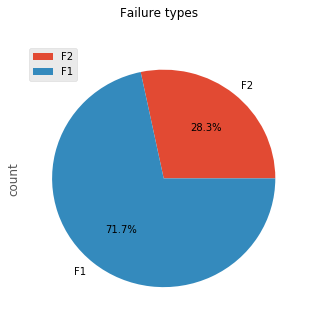

In [6]:
failures_df = logs_input_df.where(F.col('level') == 'CRITICAL')

failures_df.select('code').groupBy('code').agg(
    F.count(F.lit(1)).alias('count')
).toPandas().set_index('code').plot.pie(
    subplots=True, figsize=(5, 5), autopct='%1.1f%%', title='Failure types')

plt.show()

### Q: How many failures per machine have occured?

The output is a histogram showing the distribution of failure counts per machine.

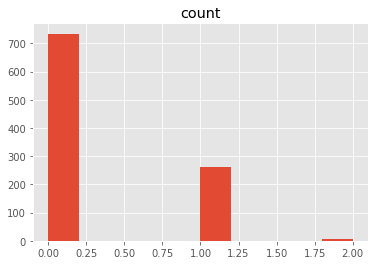

In [7]:
machine_failures_df = distinct_machines_df.join(
    failures_df, 'machineID', 'left_outer'
).groupBy('machineID').agg(F.count('code').alias('count'))

machine_failures_df.toPandas().hist()
plt.show()

### Q: What are the properties of a single machine's raw telemetry stream?

#### Descriptive statistics

In [8]:
# get ID of one of the most "faulty" machines
machineID = machine_failures_df.orderBy(F.desc('count')).first().machineID

machine_sequence_df = telemetry_input_df.where(
    telemetry_input_df.machineID == machineID
).orderBy(telemetry_input_df.timestamp)

machine_sequence_pdf = machine_sequence_df.toPandas()
machine_sequence_pdf.set_index('timestamp', inplace=True)
machine_sequence_pdf.describe()

,ambient_pressure,ambient_temperature,pressure,speed,speed_desired,temperature
count,13420.000000,13420.000000,13420.000000,13420.000000,13420.000000,13420.000000
mean,100.999055,19.999001,1503.942387,1161.254267,896.274218,141.870811
std,0.058138,0.058011,480.372262,384.890443,304.915845,6.758752
min,100.900000,19.900000,53.150000,-4.940000,0.000000,24.520000
25%,100.950000,19.950000,1414.827500,1245.577500,1000.000000,135.720000
50%,101.000000,20.000000,1549.595000,1266.090000,1000.000000,138.190000
75%,101.050000,20.050000,1811.045000,1306.065000,1000.000000,147.800000
max,101.100000,20.100000,2700.500000,1767.650000,1000.000000,154.400000


#### Temporal properties

In [9]:
# Data sample

machine_sequence_pdf.head()

,ambient_pressure,ambient_temperature,machineID,pressure,speed,speed_desired,temperature
timestamp,,,,,,,
2017-05-15 03:10:00,100.93,19.96,M_0776,233.26,620.37,1000,24.52
2017-05-15 03:10:01,100.97,20.05,M_0776,538.49,927.75,1000,30.35
2017-05-15 03:10:02,100.97,20.05,M_0776,842.67,1072.70,1000,37.67
2017-05-15 03:10:03,101.10,20.00,M_0776,1069.51,1158.65,1000,46.72
2017-05-15 03:10:04,101.00,19.90,M_0776,1214.55,1193.33,1000,57.49


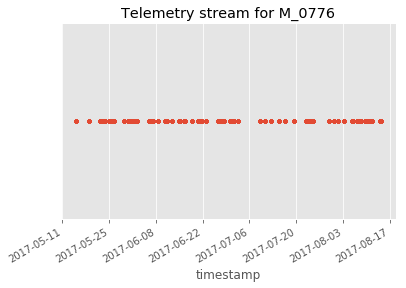

In [10]:
# Occurence of entries in the telemetry stream over time

machine_sequence_pdf.apply(lambda x: 1, axis=1).plot(
    title='Telemetry stream for {0}'.format(machineID), style='.', yticks=[])
plt.show()

In [11]:
# Telemetry frequency
# ('diffs' are computed by subtracting the previous timestamp
# from the current one for each telemetry entry)

diffs = machine_sequence_pdf.index.to_series().diff()
mode_interval = diffs.mode()[0] # mode of the time intervals
print('Telemetry frequency: {}'.format(mode_interval))

Telemetry frequency: 0 days 00:00:01


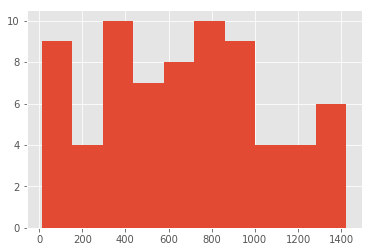

In [12]:
# Other, less common, intervals between telemetry entries (minutes)

gaps = diffs[diffs != mode_interval].dt.seconds/60
gaps.hist()
plt.show()

This shows that the machine operates in cycles followed by periods of inactivity.


## Feature creation

### Cycle-level telemetry aggregation

Raw telemetry streams, while essential for real-time monitoring and failure detection, cannot be used directly when building predictive maintenance models. The assumption is that sudden degradation during an operational cycle (for instance, a 2-8 hour flight) is rather unlikely. The common practice is to generate a single aggregate measurement to characterize the health of an asset during each unit of operation, which is commonly expressed in hours, or cycles.

In [13]:
def aggregate_cycles(df, min_gap = 30):
    """
    Detects cycles and compresses them into 
    aggregate measurements.    
    
    :param DataFrame df: input Spark DataFrame
    :param int min_gap: seconds between cycles (mininum)
    """
    w = Window.partitionBy('machineID').orderBy('timestamp')

    # Difference from the previous record or 0 if this is the first one
    diff = F.coalesce(
        F.unix_timestamp('timestamp') - F.unix_timestamp(
            F.lag('timestamp', 1).over(w)
        ), F.lit(0))

    # 0 if diff <= 30, 1 otherwise
    indicator = (diff > min_gap).cast('integer')

    subgroup = F.sum(indicator).over(w).alias('cycle')

    return df.select("*", subgroup).groupBy('machineID', 'cycle').agg(
        F.max('speed_desired').alias('speed_desired_max'),
        F.avg('speed').alias('speed_avg'),
        F.avg('temperature').alias('temperature_avg'),
        F.max('temperature').alias('temperature_max'),
        F.avg('pressure').alias('pressure_avg'),
        F.max('pressure').alias('pressure_max'),
        F.min('timestamp').alias('cycle_start'),
        F.max('timestamp').alias('cycle_end')
    ).orderBy('cycle')

#### Test on the single-machine data set

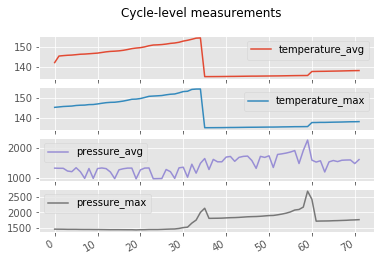

In [14]:
machine_cycles_df = aggregate_cycles(machine_sequence_df)
machine_cycles_df[['temperature_avg',
             'temperature_max',
             'pressure_avg',
             'pressure_max']].toPandas().plot(subplots=True,
                                              title='Cycle-level measurements')
plt.show()

#### Transformation of the entire data set

In [15]:
cycles_df = aggregate_cycles(telemetry_input_df)
print('Total: {0} cycle(s)'.format(cycles_df.count()))

Total: 72563 cycle(s)


### Labeling

Machine cycles preceding failure events in the logs can be assigned remaining useful life (RUL) labels based on their position in the sequence. For example, the cycle immediate before a failure is assigned RUL equal 1, and the cycle preceding it is assigned RUL equal 2, and so on.

In [16]:
# Calculating failure intervals

w = Window.partitionBy('machineID', 'level').orderBy('timestamp')
# the period between consequtive failures,
# or "since the beginning of time" if no previous failure record is on file
diff = F.coalesce(F.lag('timestamp', 1).over(w), F.to_timestamp(F.lit('2000-01-01 00:00:00')))

failure_intervals_df = (failures_df
                .withColumn('last_failure_timestamp', diff)
                .withColumnRenamed('timestamp', 'failure_timestamp')
                .withColumnRenamed('code', 'failure')
                .drop('level'))

#### Failure intervals for the selected machine

In [17]:
machine_failure_intervals_df = failure_intervals_df.where(
    F.col('machineID') == machineID)
machine_failure_intervals_df.toPandas()

,failure_timestamp,failure,machineID,last_failure_timestamp
0,2017-06-21 20:56:09,F2,M_0776,2000-01-01 00:00:00
1,2017-08-03 05:28:39,F2,M_0776,2017-06-21 20:56:09


#### Label assignment for all cycles

In addition, for each sequence of cycles running up to a failure, as well as those not ending in a failure, a unique sequence ID is generated.

In [18]:
labeled_cycles_df = (
    cycles_df.join(failure_intervals_df,
                   (cycles_df.machineID == failure_intervals_df.machineID) &
                   (cycles_df.cycle_start >= failure_intervals_df.last_failure_timestamp) &
                   (cycles_df.cycle_end <= failure_intervals_df.failure_timestamp),
                   'left_outer')
    .drop(failure_intervals_df.machineID)
    .drop(cycles_df.cycle_end)
    .drop(failure_intervals_df.last_failure_timestamp)
    .withColumnRenamed('cycle_start', 'timestamp')
    .withColumn(
     'rul',                         
      F.when(F.col('failure').isNull(), None).otherwise(
         F.row_number().over(Window.partitionBy('machineID', 'failure_timestamp')
                         .orderBy(F.desc('cycle')))))
    .withColumn(
     'sequenceID',
     F.dense_rank().over(Window.partitionBy('machineID')
                   .orderBy(F.desc('failure'), 'failure_timestamp')))
    .drop(failure_intervals_df.failure_timestamp))

#### Failure intervals and sequences for the selected machine

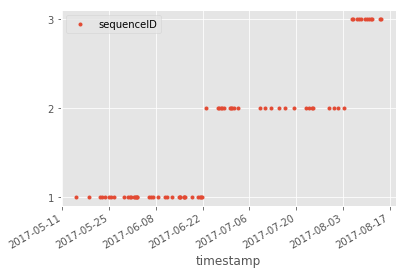

In [19]:
machine_labeled_cycles_df = labeled_cycles_df.where(
    F.col('machineID') == machineID
).select('timestamp', 'sequenceID', 'failure')

max_sequence_id = machine_labeled_cycles_df.select(
    F.max('sequenceID')).collect()[0][0]
machine_labeled_cycles_df.toPandas().set_index('timestamp').plot(
    style='.', yticks=range(1, max_sequence_id + 1))
plt.show()

In [20]:
# Labeled data set
labeled_cycles_df.printSchema()

root
 |-- machineID: string (nullable = true)
 |-- cycle: long (nullable = true)
 |-- speed_desired_max: long (nullable = true)
 |-- speed_avg: double (nullable = true)
 |-- temperature_avg: double (nullable = true)
 |-- temperature_max: double (nullable = true)
 |-- pressure_avg: double (nullable = true)
 |-- pressure_max: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- failure: string (nullable = true)
 |-- rul: integer (nullable = true)
 |-- sequenceID: integer (nullable = true)



### Augmenting data with lag features

To help characterize short-term trends for each machine, it is common practice [[3]](#ref_3) to augment the data set with new features computed over rolling windows.

In [21]:
# TODO: compute more rolling features
# (e.g., linear regression, standard deviation)

lookback = 5
w = Window.partitionBy(
    'machineID', 'sequenceID'
).rowsBetween(-lookback, Window.currentRow).orderBy('cycle')

# computing rolling averages for these cycle-level features
input_columns = ['temperature_avg', 'temperature_max', 'pressure_avg', 'pressure_max']

# adding rolling features and eliminating the entries in the beginning of each
# sequence which weren't computed using a sufficient number of previous values
augmented_labeled_cycles_df = (
    reduce(lambda _df, ic: _df.withColumn(
        '{0}_avg'.format(ic), F.avg(ic).over(w)), input_columns, labeled_cycles_df)
    .withColumn('is_valid', F.count(F.lit(1)).over(w) > lookback)
    .where(F.col('is_valid'))
    .drop('is_valid'))

augmented_labeled_cycles_df.printSchema()

root
 |-- machineID: string (nullable = true)
 |-- cycle: long (nullable = true)
 |-- speed_desired_max: long (nullable = true)
 |-- speed_avg: double (nullable = true)
 |-- temperature_avg: double (nullable = true)
 |-- temperature_max: double (nullable = true)
 |-- pressure_avg: double (nullable = true)
 |-- pressure_max: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- failure: string (nullable = true)
 |-- rul: integer (nullable = true)
 |-- sequenceID: integer (nullable = true)
 |-- temperature_avg_avg: double (nullable = true)
 |-- temperature_max_avg: double (nullable = true)
 |-- pressure_avg_avg: double (nullable = true)
 |-- pressure_max_avg: double (nullable = true)



## Persisting the feature data set

For the sake of generality, all domain-specific feature names will be obfuscated, and explicit timestamps will be replaced with numeric entry IDs indicating the relative temporal order.

In [22]:
feature_columns = [
    c for c in augmented_labeled_cycles_df.columns if c not in (
        'machineID', 'cycle', 'sequenceID', 'rul', 'failure', 'timestamp')]
obfuscate_columns = zip(feature_columns, range(1, len(feature_columns) + 1))

feature_df = reduce(lambda _df, ic: _df.withColumnRenamed(ic[0], 's{0}'.format(ic[1])),
    obfuscate_columns, augmented_labeled_cycles_df).withColumn(
    'entryID', F.row_number().over(Window().orderBy('timestamp'))
).drop('timestamp')

feature_df.printSchema()

root
 |-- machineID: string (nullable = true)
 |-- cycle: long (nullable = true)
 |-- s1: long (nullable = true)
 |-- s2: double (nullable = true)
 |-- s3: double (nullable = true)
 |-- s4: double (nullable = true)
 |-- s5: double (nullable = true)
 |-- s6: double (nullable = true)
 |-- failure: string (nullable = true)
 |-- rul: integer (nullable = true)
 |-- sequenceID: integer (nullable = true)
 |-- s7: double (nullable = true)
 |-- s8: double (nullable = true)
 |-- s9: double (nullable = true)
 |-- s10: double (nullable = true)
 |-- entryID: integer (nullable = true)



In [23]:
% rm -rf data/features

chunks = 5 # split the data into N chunks
feature_df.coalesce(chunks).write.csv('data/features', header=True)

## References
https://www.youtube.com/watch?v=drUToKxEAUA

http://waset.org/publications/10006640/building-a-scalable-telemetry-based-multiclass-predictive-maintenance-model-in-r

http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.386.8108&rep=rep1&type=pdf